# Содержание <a id="содержание"></a>

- [1 Отток клиентов](#1)
 - [1.1 Задание](#1_1)
 - [1.2 Описание данных](#1_2)
- [2 Подготовка данных](#2)
 - [2.1 Загрузка данных](#2_1)
 - [2.2 Предобработка данных](#2_2)
 - [2.3 Масштабирование и кодирование признаков](#2_3)
- [3 Исследование задачи](#3)
 - [3.1 Формирование обучающей, валидационной и тестовой выборок](#3_1)
 - [3.2 Случайный лес](#3_2)
 - [3.3  Логистическая регрессия](#3_3)
 - [3.4 Вывод](#3_4)
- [4 Борьба с дисбалансом](#4)
 - [4.1 Случайный лес](#4_1)
 - [4.2 Логистическая регрессия](#4_2)
 - [4.3 Вывод](#4_3)
- [5 Тестирование модели](#5)
- [6 Вывод](#6)
- [7 Чек-лист готовности модели](#7)

# 1 Отток клиентов [▲](#содержание) <a id="1"></a>

## 1.1 Задание [▲](#содержание) <a id="1_1"></a>

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## 1.2 Описание данных [▲](#содержание) <a id="1_2"></a>

Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

Целевой признак:
- Exited — факт ухода клиента

## 2 Подготовка данных [▲](#содержание) <a id="2"></a>

### 2.1 Загрузка данных [▲](#содержание) <a id="2_1"></a>

Подключим модули языка Python.

In [1]:
# Подключение модулей

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
pd.options.mode.chained_assignment = None

%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
def df_info(data_frame, nulls_percent_round=1, deep_memory_usage=False):
    '''
    Функция для вывода общей информации о таблице
    '''
    t = pd.concat(
        [
         
            data_frame.isna().sum().to_frame('nulls_count'),
            (100 * data_frame.isna().sum() / len(data_frame)).round(nulls_percent_round).to_frame('nulls_percent'),
            data_frame.dtypes.to_frame('dtype')
        ],
        axis=1
    )
    s = 'dtypes:'
    c = data_frame.dtypes.value_counts()
    for i in c.index:
        s += ' {0}({1})'.format(i, c[i])
    m = data_frame.memory_usage(deep=deep_memory_usage).sum()
    if int(m / 1024 ** 3):
        d, b = 1024 ** 3, 'GB'
    elif int(m / 1024 ** 2):
        d, b = 1024 ** 2, 'MB'
    else:
        d, b = 1024, 'KB'
    print(t)
    print('columns: ', data_frame.shape[1], ', rows: ', data_frame.shape[0], sep='')
    print(s)
    print('memory_usage: ', round(m / d, 1), '+ ' if not deep_memory_usage else ' ', b, sep='')

def upsample(features, target, repeat, positive=True):
    '''
    Функция увеличения выборки
    '''
    # Разделение выборок на объекты по классам
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # Увеличение количества положительных или отрицательных объектов в зависимости от параметра
    if positive:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    else:
        features_upsampled = pd.concat([features_zeros] * repeat + [features_ones])
        target_upsampled = pd.concat([target_zeros] * repeat + [target_ones])
    # Перетасовка выборок
    features_upsampled, target_upsampled =\
        shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

def downsample(features, target, fraction, positive=True):
    '''
    Функция уменьшения выборки
    '''
    # Разделение выборок на объекты по классам
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    # Уменьшение количества положительных или отрицательных объектов в зависимости от параметра
    if positive:
        features_downsampled = pd.concat([features_zeros] + [features_ones.sample(frac=fraction, random_state=12345)])
        target_downsampled = pd.concat([target_zeros] + [target_ones.sample(frac=fraction, random_state=12345)])
    else: 
        features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
        target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled =\
        shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

Загрузим таблицу исходных данных о клиентах "Бета-Банка".

In [3]:
# Загрузка данных (код из одного из предыдущих проектов)

# Возможные пути расположения файлов
filepaths = {
    'data': ['/datasets/Churn.csv', './Churn.csv', 'https://code.s3.yandex.net/datasets/Churn.csv']
}

# Загрузка данных по первому валидному пути
for k in filepaths.keys():
    for filepath in filepaths[k]:
        try:
            dfvarname = k
            exec(dfvarname + ' = pd.read_csv(filepath)')
            print('Таблица ' + k + ' из файла ' + filepath + ' загружена в переменную ' + dfvarname)
            break
        except Exception:
            continue
    else:
        raise SystemExit('Файл с таблицей ' + k + ' не найден ни по одному из путей в списке filepaths')

Таблица data из файла https://code.s3.yandex.net/datasets/Churn.csv загружена в переменную data


### 2.2 Предобработка данных [▲](#содержание) <a id="2_2"></a>

Выведем начало таблицы.

In [4]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,2,15647311,Hill,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,3,15619304,Onio,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,4,15701354,Boni,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,5,15737888,Mitchell,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


Также выведем общую информацию о таблице.

In [5]:
df_info(data)

                 nulls_count  nulls_percent    dtype
RowNumber                  0           0.00    int64
CustomerId                 0           0.00    int64
Surname                    0           0.00   object
CreditScore                0           0.00    int64
Geography                  0           0.00   object
Gender                     0           0.00   object
Age                        0           0.00    int64
Tenure                   909           9.10  float64
Balance                    0           0.00  float64
NumOfProducts              0           0.00    int64
HasCrCard                  0           0.00    int64
IsActiveMember             0           0.00    int64
EstimatedSalary            0           0.00  float64
Exited                     0           0.00    int64
columns: 14, rows: 10000
dtypes: int64(8) object(3) float64(3)
memory_usage: 1.1+ MB


В наборе признаков, по которым будет осуществляться обучение моделей, явно лишними являются порядковый номер строки RowNumber и персональные данные клиента CustomerId и Surname. Во-первых, бессмысленно само целеполагание, во-вторых, с такими значениями на этапе кодирования переменных OHE устроит нам "большой взрыв". ) Удалим эти столбцы из таблицы.

In [6]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.00,0.00,1,1,1,"101,348.88",1
1,608,Spain,Female,41,1.00,"83,807.86",1,0,1,"112,542.58",0
2,502,France,Female,42,8.00,"159,660.80",3,1,0,"113,931.57",1
3,699,France,Female,39,1.00,0.00,2,0,0,"93,826.63",0
4,850,Spain,Female,43,2.00,"125,510.82",1,1,1,"79,084.10",0


Таблица содержит пропуски, все они имеют место в столбце Tenure, содержащем информацию о том, сколько лет человек является клиентом банка. Рассмотрим этот столбец последним.

Проанализируем категориальный столбец Geography. Выведем его уникальные значения.

In [7]:
data.Geography.value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Все хорошо, дубликатов нет.

На всякий случай ознакомимся с количеством полов в столбце Gender. Хоть бы 2, а не 48, 76 или сколько их там сейчас...

In [8]:
data.Gender.value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

Обошлось. Только дяденьки и тетеньки.

Столбец Age.

In [9]:
data.Age.describe()

count   10,000.00
mean        38.92
std         10.49
min         18.00
25%         32.00
50%         37.00
75%         44.00
max         92.00
Name: Age, dtype: float64

Без аномалий. Клиенты банка &mdash; люди в возрасте от 18 до 92 лет. Средний и медианный возрасты &mdash; 38.92 года и 37 лет, соответственно.

Столбец NumOfProducts с количеством продуктов банка, используемых клиентом.

In [10]:
data.NumOfProducts.value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

Минимальное количество продуктов банка 1, максимальное &mdash; 4.

Категориальные столбцы HasCrCard и IsActiveMembe.

In [11]:
data.HasCrCard.value_counts()

1    7055
0    2945
Name: HasCrCard, dtype: int64

In [12]:
data.IsActiveMember.value_counts()

1    5151
0    4849
Name: IsActiveMember, dtype: int64

Здесь также все впорядке.

Количественные столбцы Balance и EstimatedSalary.

In [13]:
data[['Balance', 'EstimatedSalary']].describe()

,Balance,EstimatedSalary
count,"10,000.00","10,000.00"
mean,"76,485.89","100,090.24"
std,"62,397.41","57,510.49"
min,0.00,11.58
25%,0.00,"51,002.11"
50%,"97,198.54","100,193.91"
75%,"127,644.24","149,388.25"
max,"250,898.09","199,992.48"


Как минимум у четверти клиентов на счету 0 &#8381;. Заемщики? Оценочная зарплата 11.58 &#8381; также вызывает некоторые вопросы. Выведем несколько ее минимальных значений.

In [14]:
data.EstimatedSalary.sort_values().head()

2362    11.58
9647    90.07
9010    91.75
5548    96.27
4989   106.67
Name: EstimatedSalary, dtype: float64

Странно все это. С другой стороны, возможно, так зарплату оценивает какой-нибудь алгоритм по косвенным данным. Не каждый же клиент берет в этом банке кредит, для чего предоставляет справку о доходах. Оставим данные значения.

Убедимся, что столбец Exited с целевым признаком не содержит мусора.

In [15]:
data.Exited.value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Наблюдается дисбаланс классов. Вычислим доли классов целевого признака в процентах.

In [16]:
(100 * data.Exited.value_counts() / len(data)).to_frame('Доля классов, %')

,"Доля классов, %"
0,79.63
1,20.37


Рассмотрим припасенный на последок столбец Tenure, содержащий пропуски.

In [17]:
data.Tenure.unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Доля пропусков 9.1%. Природа появления пропусков в данном столбце неясна, поэтому предпочтительнее будет удалить их, а не заменять, например, на характерные значения. Исследуем, как повлияет удаление объектов с пропусками в столбце Tenure на баланс классов целевого признака.

In [18]:
(100 * data[data.Tenure.notna()].Exited.value_counts() / len(data[data.Tenure.notna()])).to_frame('Доля классов, %')

,"Доля классов, %"
0,79.61
1,20.39


Баланс классов в целевом признаке практически не изменился. Удалим объекты с пропусками.

In [19]:
data = data.dropna().reset_index(drop=True)
data.tail()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9086,800,France,Female,29,2.00,0.00,2,0,0,"167,773.55",0
9087,771,France,Male,39,5.00,0.00,2,1,0,"96,270.64",0
9088,516,France,Male,35,10.00,"57,369.61",1,1,1,"101,699.77",0
9089,709,France,Female,36,7.00,0.00,1,0,1,"42,085.58",1
9090,772,Germany,Male,42,3.00,"75,075.31",2,1,0,"92,888.52",1


### 2.3 Масштабирование и кодирование признаков [▲](#содержание) <a id="2_3"></a>

Выделим столбцы с количественными признаками и проанализируем их описательную статистику.

In [20]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
data[numeric].describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
count,"9,091.00","9,091.00","9,091.00","9,091.00","9,091.00","9,091.00"
mean,650.74,38.95,5.00,"76,522.74",1.53,"100,181.21"
std,96.41,10.56,2.89,"62,329.53",0.58,"57,624.76"
min,350.00,18.00,0.00,0.00,1.00,11.58
25%,584.00,32.00,2.00,0.00,1.00,"51,227.74"
50%,652.00,37.00,5.00,"97,318.25",1.00,"100,240.20"
75%,717.00,44.00,7.00,"127,561.89",2.00,"149,567.21"
max,850.00,92.00,10.00,"250,898.09",4.00,"199,992.48"


Количественные признаки существенно различающиеся по среднему значению и разбросу. Чтобы модель не отдавала предпочтение признакам определенной величины и разброса, осуществим их стандартизацию. Выведем начало измененной таблицы.

In [21]:
# Обучение преобразователя масштаба
scaler = StandardScaler()
scaler.fit(data[numeric])

# Масштабирование количественных признаков
data[numeric] = scaler.transform(data[numeric])

data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,-0.33,France,Female,0.29,-1.04,-1.23,-0.91,1,1,0.02,1
1,-0.44,Spain,Female,0.19,-1.38,0.12,-0.91,0,1,0.21,0
2,-1.54,France,Female,0.29,1.04,1.33,2.53,1,0,0.24,1
3,0.50,France,Female,0.00,-1.38,-1.23,0.81,0,0,-0.11,0
4,2.07,Spain,Female,0.38,-1.04,0.79,-0.91,1,1,-0.37,0


Так как модели машинного обучения работают с числовыми признаками, необходимо закодировать строковые категориальные данные. Будем использовать технику прямого кодирования (One-Hot Encoding), как более универсальную: работает с логистической регрессией в отличие от техники порядкового кодирования (Ordinal Encoding).

In [22]:
data = pd.get_dummies(data, drop_first=True)
data.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.33,0.29,-1.04,-1.23,-0.91,1,1,0.02,1,0,0,0
1,-0.44,0.19,-1.38,0.12,-0.91,0,1,0.21,0,0,1,0
2,-1.54,0.29,1.04,1.33,2.53,1,0,0.24,1,0,0,0
3,0.50,0.00,-1.38,-1.23,0.81,0,0,-0.11,0,0,0,0
4,2.07,0.38,-1.04,0.79,-0.91,1,1,-0.37,0,0,1,0


## 3 Исследование задачи [▲](#содержание) <a id="3"></a>

### 3.1 Формирование обучающей, валидационной и тестовой выборок  [▲](#содержание)  <a id="3_1"></a>

Разделим исходный набор данных на нецелевые и целевые признаки объектов.

In [23]:
features, target = data.drop(columns='Exited'), data.Exited

Полученные данные разделим на обучающую, валидационную и тестовую выборки в соотношении 3:1:1. Для равномерного распределения классов в результирующих выборках зададим соответствующим образом параметр стратификации.

In [24]:
features_train_and_valid, features_test, target_train_and_valid, target_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=12345,
    stratify=target)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_and_valid,
    target_train_and_valid,
    test_size=0.25,
    random_state=12345,
    stratify=target_train_and_valid)

Оценим дисбаланс классов в обучающей выборке. Выведем их доли в процентах.

In [25]:
(100 * target_train.value_counts() / len(target_train)).to_frame('Доля классов, %')

,"Доля классов, %"
0,79.61
1,20.39


Отношение положительного и отрицательного классов примерно к 1:4, что свидетельствует об их дисбалансе.

Попробуем получить удовлетворительное качество классификации с помощью случайного леса и логистической регрессии, обученных на несбалансированной выборке. В качестве метрики оценки качества будем использовать F1-меру. Качество распознавания будем считать удовлетворительным, если значение F1-меры на тестовой выборке будет равно или превысит 0.59.

### 3.2 Случайный лес [▲](#содержание) <a id="3_2"></a>

Сперва обучим модель случайного леса. Попробуем различные значения таких гиперпараметров как число деревьев и максимальная глубина обучения каждого дерева.

In [26]:
%timeit
best_rf_model, best_rf_score = None, 0
for depth in range(2, 22, 2):
    for n_est in range(20, 220, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_est, max_depth=depth).\
            fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_rf_score:
            best_rf_n_est, best_rf_max_depth, best_rf_model, best_rf_score = n_est, depth, model, score
print('Случайный лес с лучшим результатом на валидационной выборке')
print('Модель:          ', best_rf_model)
print('Значение F1-меры:', round(best_rf_score, 4))

Случайный лес с лучшим результатом на валидационной выборке
Модель:           RandomForestClassifier(max_depth=12, n_estimators=20, random_state=12345)
Значение F1-меры: 0.5792


Значение F1-меры не дотягивает до требуемого. Попытаемся улучшить ее значение подбором порога классификации.

In [27]:
probabilities_one_valid = best_rf_model.predict_proba(features_valid)[:, 1]
best_rf_score, best_rf_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_rf_score:
        best_rf_score = score
        best_rf_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_rf_threshold, best_rf_score))

Порог = 0.29, F1-мера = 0.6118


Сохраним финальное значение модели случайного леса и порога в соответствующих переменных. Будем перезаписывать их значения, если далее удастся улучшить качество модели.

In [28]:
final_rf_model = best_rf_model
final_rf_threshold = best_rf_threshold

### 3.3 Логистическая регрессия [▲](#содержание) <a id="3_3"></a>

Также обучим модель логистической регресии для разных значений максимального количества итераций, необходимых для схождения решателей.

In [29]:
%timeit
best_lr_model, best_lr_score = None, 0
for max_iter in range(50, 550, 50):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=max_iter).\
        fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_max_iter, best_lr_model, best_lr_score = max_iter, model, score
print('Логистическая регрессия с лучшим результатом на валидационной выборке')
print('Лучшая модель:   ', best_lr_model)
print('Значение F1-меры:', round(best_lr_score, 4))

Логистическая регрессия с лучшим результатом на валидационной выборке
Лучшая модель:    LogisticRegression(max_iter=50, random_state=12345, solver='liblinear')
Значение F1-меры: 0.2828


Значение F1-меры значительно уступает требуему. Также попробуем подобрать оптимальное значение порога классификации.

In [30]:
probabilities_one_valid = best_lr_model.predict_proba(features_valid)[:, 1]
best_lr_score, best_lr_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_score = score
        best_lr_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_lr_threshold, best_lr_score))

Порог = 0.22, F1-мера = 0.4945


In [31]:
final_lr_model = best_lr_model
final_lr_threshold = best_lr_threshold

### 3.4 Вывод [▲](#содержание) <a id="3_4"></a>

Обучение случайного леса и логистической регрессии проводилось на несбалансированной выборке. При этом на валидационной выборке удалось довести значение F1-меры до отвечающего требованию только для случайного леса с 20 деревьями и максимальной глубиной обучения 12 при использовании порога классификации 0.29. Достигнутое значение F1-меры составило 0.6118.

## 4 Борьба с дисбалансом [▲](#содержание) <a id="4"></a>

### 4.1 Случайный лес [▲](#содержание) <a id="4_1"></a>

Попробуем нивелировать эффект от дисбаланса классов их взвешиванием на этапе обучения модели. Обучим случайный лес, перебирая те же значения гиперпараметров, что и в предыдущих случаях, но уже со взвешиванием классов. Подберем оптимальный порог классификации.

In [32]:
%timeit
best_rf_model, best_rf_score = None, 0
for depth in range(2, 22, 2):
    for n_est in range(20, 220, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_est, max_depth=depth, class_weight='balanced').\
            fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_rf_score:
            best_rf_n_est, best_rf_max_depth, best_rf_model, best_rf_score = n_est, depth, model, score
print('Случайный лес с лучшим результатом на валидационной выборке')
print('Модель:          ', best_rf_model)
print('Значение F1-меры:', round(best_rf_score, 4))

Случайный лес с лучшим результатом на валидационной выборке
Модель:           RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=120,
                       random_state=12345)
Значение F1-меры: 0.6119


In [33]:
probabilities_one_valid = best_rf_model.predict_proba(features_valid)[:, 1]
best_rf_score, best_rf_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_rf_score:
        best_rf_score = score
        best_rf_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_rf_threshold, best_rf_score))

Порог = 0.53, F1-мера = 0.6134


Значение F1-меры на валидационной выборке для случайного леса превысило предыдущий лучший результат. Сохраним полученные модель и порог классификации. Исследуем, возможно ли дальнейшее улучшение модели случайного леса с помощью балансировки классов увеличением количества объектов меньшего класса или, наоборот, отбрасыванием части объектов большего класса в обучающей выборке.

In [34]:
final_rf_model = best_rf_model
final_rf_threshold = best_rf_threshold

В обучающей выборке больший (преобладающий) класс &mdash; отрицательный, его доля близка к 80%, доля положительного класса, соответственно, к 20%. Продублируем объекты меньшего положительного класса так, чтобы доли обоих классов сравнялись. Отобразим новый баланс классов.

In [35]:
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)
(100 * target_train_upsampled.value_counts() / len(target_train_upsampled)).to_frame('Доля классов, %')

,"Доля классов, %"
1,50.60
0,49.40


Почти поровну. Выведем размеры исходной и увеличенной обучающих выборок.

In [36]:
len(target_train), len(target_train_upsampled)

(5454, 8790)

Обучим случайный лес. Так как дисбаланса классов нет, уберем взвешивание классов.

In [37]:
%timeit
best_rf_model, best_rf_score = None, 0
for depth in range(2, 22, 2):
    for n_est in range(20, 220, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_est, max_depth=depth).\
            fit(features_train_upsampled, target_train_upsampled)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_rf_score:
            best_rf_n_est, best_rf_max_depth, best_rf_model, best_rf_score = n_est, depth, model, score
print('Случайный лес с лучшим результатом на валидационной выборке')
print('Модель:          ', best_rf_model)
print('Значение F1-меры:', round(best_rf_score, 4))

Случайный лес с лучшим результатом на валидационной выборке
Модель:           RandomForestClassifier(max_depth=12, n_estimators=60, random_state=12345)
Значение F1-меры: 0.6088


Стало хуже, вернем взвешивание обратно. ^^

In [38]:
%timeit
best_rf_model, best_rf_score = None, 0
for depth in range(2, 22, 2):
    for n_est in range(20, 220, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_est, max_depth=depth, class_weight='balanced').\
            fit(features_train_upsampled, target_train_upsampled)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_rf_score:
            best_rf_n_est, best_rf_max_depth, best_rf_model, best_rf_score = n_est, depth, model, score
print('Случайный лес с лучшим результатом на валидационной выборке')
print('Модель:          ', best_rf_model)
print('Значение F1-меры:', round(best_rf_score, 4))

Случайный лес с лучшим результатом на валидационной выборке
Модель:           RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=120,
                       random_state=12345)
Значение F1-меры: 0.6156


Удалось еще незначительно улучшить значение F1-меры по сравнению с предыдущим лучшим результатом. Будем считать, что на данном этапе оптимальные параметры обучения случайного леса найдены. Как и в случае с обучением на несбалансированной выборке, попробуем улучшить качество классификации подбором оптимального значения порога классификации.

In [39]:
probabilities_one_valid = best_rf_model.predict_proba(features_valid)[:, 1]
best_rf_score, best_rf_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_rf_score:
        best_rf_score = score
        best_rf_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_rf_threshold, best_rf_score))

Порог = 0.50, F1-мера = 0.6156


Оптимальный порог &mdash; порог по умолчанию. Сохраним модель и порог классификации.

In [40]:
final_rf_model = best_rf_model
final_rf_threshold = best_rf_threshold

Проверим ради интереса, как на качество обучения модели повлияет достижение баланса классов с помощью уменьшения количества объектов большего (в нашем случае отрицательного) класса. Ввыведем новые значений долей классов.

In [41]:
features_train_downsampled, target_train_downsampled = downsample(features_train, target_train, 0.25, positive=False)
(100 * target_train_downsampled.value_counts() / len(target_train_downsampled)).to_frame('Доля классов, %')

,"Доля классов, %"
1,50.59
0,49.41


Значения долей очень близки.

Выведем размеры исходной и уменьшенной тренировочных выборок. Можно предположить, что удаление части объектов из обучающей выборки негативно скажется на качестве модели.

In [42]:
len(target_train), len(target_train_downsampled)

(5454, 2198)

Снова обучим случайный лес. На этот раз не будем убирать взвешивание классов.

In [43]:
%timeit
best_rf_model, best_rf_score = None, 0
for depth in range(2, 22, 2):
    for n_est in range(20, 220, 20):
        model = RandomForestClassifier(random_state=12345, n_estimators=n_est, max_depth=depth, class_weight='balanced').\
            fit(features_train_downsampled, target_train_downsampled)
        predicted_valid = model.predict(features_valid)
        score = f1_score(target_valid, predicted_valid)
        if score > best_rf_score:
            best_rf_n_est, best_rf_max_depth, best_rf_model, best_rf_score = n_est, depth, model, score
print('Случайный лес с лучшим результатом на валидационной выборке')
print('Модель:          ', best_rf_model)
print('Значение F1-меры:', round(best_rf_score, 4))

Случайный лес с лучшим результатом на валидационной выборке
Модель:           RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=140,
                       random_state=12345)
Значение F1-меры: 0.5894


Подберем порог классификации.

In [44]:
probabilities_one_valid = best_rf_model.predict_proba(features_valid)[:, 1]
best_rf_score, best_rf_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_rf_score:
        best_rf_score = score
        best_rf_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_rf_threshold, best_rf_score))

Порог = 0.69, F1-мера = 0.6009


Качество модели случайного леса по сравнению с предыдущим лучшим результатом улучшить не удалось.

Подведем итог. На данный момент лучшее значение F1-меры, равное 0.6156, демонстрирует случайный лес с количеством деревьев 120, максимальной глубиной обучения 12, обученный со взвешиванием классов на тренировочной выборке, сбалансированной увеличением (копированием) количества объектов меньшего класса.

### 4.2 Логистическая регрессия [▲](#содержание) <a id="4_2"></a>

Проведем аналогичное исследование влияния сбалансированности обучающей выборки на качество модели логистической регрессии. Сперва обучим логистическую регрессию на исходной выборке со взвешиванием классов.

In [45]:
%timeit
best_lr_model, best_lr_score = None, 0
for max_iter in range(50, 550, 50):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=max_iter, class_weight='balanced').\
        fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_max_iter, best_lr_model, best_lr_score = max_iter, model, score
print('Логистическая регрессия с лучшим результатом на валидационной выборке')
print('Лучшая модель:   ', best_lr_model)
print('Значение F1-меры:', round(best_lr_score, 4))

Логистическая регрессия с лучшим результатом на валидационной выборке
Лучшая модель:    LogisticRegression(class_weight='balanced', max_iter=50, random_state=12345,
                   solver='liblinear')
Значение F1-меры: 0.4957


In [46]:
probabilities_one_valid = best_lr_model.predict_proba(features_valid)[:, 1]
best_lr_score, best_lr_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_score = score
        best_lr_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_lr_threshold, best_lr_score))

Порог = 0.50, F1-мера = 0.4957


In [47]:
final_lr_score = best_lr_score
final_lr_threshold = best_lr_threshold

Наблюдается незначительное улучшение качества модели по сравнение с обучением без взвешивания, при этом последующая коррекция с помощью порога классификации не привела к росту значения F1-меры по сравнению с его значением по умолчанию.

Обучим модель логистической регрессии на увеличенной сбалансированной выборке, используемой ранее для обучения случайного леса,  со взвешиванием. Подберем оптимальный порог классификации.

In [48]:
%timeit
best_lr_model, best_lr_score = None, 0
for max_iter in range(50, 550, 50):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=max_iter, class_weight='balanced').\
        fit(features_train_upsampled, target_train_upsampled)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_max_iter, best_lr_model, best_lr_score = max_iter, model, score
print('Логистическая регрессия с лучшим результатом на валидационной выборке')
print('Лучшая модель:   ', best_lr_model)
print('Значение F1-меры:', round(best_lr_score, 4))

Логистическая регрессия с лучшим результатом на валидационной выборке
Лучшая модель:    LogisticRegression(class_weight='balanced', max_iter=50, random_state=12345,
                   solver='liblinear')
Значение F1-меры: 0.4957


In [49]:
probabilities_one_valid = best_lr_model.predict_proba(features_valid)[:, 1]
best_lr_score, best_lr_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_score = score
        best_lr_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_lr_threshold, best_lr_score))

Порог = 0.50, F1-мера = 0.4957


Повторим для уменьшенной обучающей выборки, также используемой ранее для обучения случайного леса.

In [50]:
%timeit
best_lr_model, best_lr_score = None, 0
for max_iter in range(50, 550, 50):
    model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=max_iter, class_weight='balanced').\
        fit(features_train_downsampled, target_train_downsampled)
    predicted_valid = model.predict(features_valid)
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_max_iter, best_lr_model, best_lr_score = max_iter, model, score
print('Логистическая регрессия с лучшим результатом на валидационной выборке')
print('Лучшая модель:   ', best_lr_model)
print('Значение F1-меры:', round(best_lr_score, 4))

Логистическая регрессия с лучшим результатом на валидационной выборке
Лучшая модель:    LogisticRegression(class_weight='balanced', max_iter=50, random_state=12345,
                   solver='liblinear')
Значение F1-меры: 0.4851


In [51]:
probabilities_one_valid = best_lr_model.predict_proba(features_valid)[:, 1]
best_lr_score, best_lr_threshold = 0, 0
for threshold in np.arange(0, 1, 0.01):
    predicted_valid = probabilities_one_valid > threshold
    score = f1_score(target_valid, predicted_valid)
    if score > best_lr_score:
        best_lr_score = score
        best_lr_threshold = threshold
print("Порог = {:.2f}, F1-мера = {:.4f}".format(best_lr_threshold, best_lr_score))

Порог = 0.53, F1-мера = 0.4969


Обучение логистической регрессии на выборках, сбалансированных копированием объектов меньшего класса и отбрасыванием объектов большего класса, с использованием взвешивания классов на этапе обучения, не позволило довести значения F1-меры до требуемого.

### 4.3 Вывод [▲](#содержание) <a id="4_3"></a>

В случае со случайным лесом положительно на качестве классификации повлияли обучение со взвешиванием классов и обучение на выборке, сбалансированной путем увеличения количества объектов меньшего класса. Одновременно оба эти фактора позволили получить максимальное значение F1-меры 0.6156. При этом коррекция порога классификации не понадобилась. Приведенное значение F1-меры достигалось при стандартном значении порога классификации 0.5.

В отличие от случайного леса, на качество логистической регрессии взвешивание классов исходной обучающей выборки не привело к увеличению F1-меры. Использование сбалансированной увеличенной выборки и последующая коррекция порога классификации до 0.53 хоть привели к росту значения F1-меры, но не позволили достичь порогового значения.

## 5 Тестирование модели [▲](#содержание) <a id="5"></a>

Протестируем лучшую модель случайного леса на тестовой выборке. Вычислим значение метрики AUC-ROC и построим ROC-кривую.

In [52]:
predicted_test = final_rf_model.predict(features_test)
probabilities_one_test = final_rf_model.predict_proba(features_test)[:, 1]
print('Лучшая модель случайного леса на тестовой выборке')
print('Значение F1-меры:', round(f1_score(target_test, predicted_test), 4))
print('Значение AUC ROC:', round(roc_auc_score(target_test, probabilities_one_test), 4))

Лучшая модель случайного леса на тестовой выборке
Значение F1-меры: 0.614
Значение AUC ROC: 0.8539


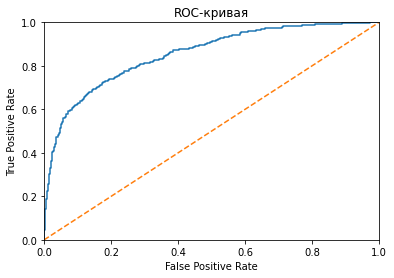

In [53]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate'),
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Переобучим эту же модель на сумме обучающей и валидационной выборок, после чего испытаем ее на тестовой выборке. Также вычислим  значение метрики AUC-ROC и построим ROC-кривую.

In [54]:
final_rf_model_fully_trained =\
    RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=120, random_state=12345).\
        fit(features_train_and_valid, target_train_and_valid)
predicted_test = final_rf_model_fully_trained.predict(features_test)
probabilities_one_test = final_rf_model_fully_trained.predict_proba(features_test)[:, 1]
print('Лучшая модель случайного леса, обученная на сумме обучающей и валидационной выборок, на тестовой выборке')
print('Значение F1-меры:', round(f1_score(target_test, predicted_test), 4))
print('Значение AUC ROC:', round(roc_auc_score(target_test, probabilities_one_test), 4))

Лучшая модель случайного леса, обученная на сумме обучающей и валидационной выборок, на тестовой выборке
Значение F1-меры: 0.6299
Значение AUC ROC: 0.8596


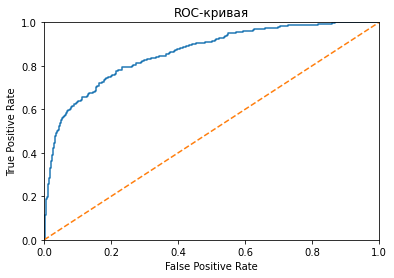

In [55]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test) # < напишите код здесь >
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') # ROC-кривая случайной модели
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate'),
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

В обоих случаях на тестовой выборке значение F1-меры превышает заданное. Значение AUC-ROC превышает 0.5, что означает, что модель работает эффективней случайной модели. ROC-кривая проходит достаточно высоко над пунктирной прямой случайного классификатора.

## 6 Вывод [▲](#содержание) <a id="6"></a>

Проведено исследование качества классификации случайного леса и логистической регрессии на данных клиентов "Бета-банка". Целевым признаком являлся факт ухода клиента из банка в столбце Exited.

Перед обучением и тестированием моделей данные были предобработаны:
 - удалены столбцы RowNumber, CustomerId, Surname, хранящие данные, не являющиеся признаками;
 - удалены 909 объектов, имеющие пропуски в столбце Tenure.

Удаление объектов с пропусками не оказало значительного влияния на объем таблицы и на значения долей классов целевого признака.

Так как рассматриваемые алгоритмы машинного обучения работают с числовым представлением входных признаков, было осуществлено кодирование строковых категориальных переменных. Использовалась методика прямого кодирования One-Hot Encoding, как наиболее универсальная.

После предобработки данные были разбиты на нецелевые и целевой признаки. Из каждой таблицы были сформированы обучающая, валидационная и тренировочная выборки в соотношении 3:1:1.

Было установлено, что обучающая выборка имеет значительный дисбаланс классов: большим классом оказался отрицательный класс с долей приблизительно 80%, меньшим &mdash; положительный класс с долей приблизительно 20%.

Первоначально обучение проходило на несбалансированной выборке. Проверялись разные значения гиперпараметров: для случайного леса &mdash; число деревьев и максимальная глубина обучения, для логистической регрессии &mdash; максимальное количество итераций, необходимое для схождения решателя.

В результате на валидационной выборке только случайный лес смог продемонстрировать значение F1-меры свыше требуемого (0.59), оно составило 0.6156. В то время как лучшее значение F1-меры для логистической регрессии составило 0.4851.

Для балансировки обучающей выборки были применены взвешивание классов обучающей выборки, увеличение обучающей выборки дублированием объектов меньшего класса и уменьшение обучающей выборки отбрасыванием объектов большего класса.

Взвешивание на этапе обучения оказало значительный эффект только на случайный лес, в то время как для логистической регрессии значение F1-меры не изменилось. В обоих случаях небольшой положительный эффект оказало увеличение количества объектов меньшего класса в обучающей выборке.

Случайный лес и логистическая регрессия, обученные на сбалансированной выборке, показали на валидационной выборке лучшие значения F1-меры 0.6156 и 0.4969 соответственно.

На тестовой выборке проверялся только случайный лес. Также для него было рассчитано значение метрики AUC-ROC и построена ROC-кривая:
 - значение F1-меры составило 0.614;
 - значение AUC ROC метрики составило 0.8539.
ROC-кривая прошла значительно выше линии случайного классификатор.

Случайный лес с аналогичными параметрами был обучен на сумме обучающей и валидационной выборок, проверен на тестовой выборке:
 - значение F1-меры составило 0.6299;
 - значение AUC ROC метрики составило 0.8596.


Удалось еще незначительно улучшить качество классификации. ROC-кривая зрительно почти не отличалась от ROC-кривой для случайного леса, обученного только на обучающей выборке.

## 7 Чек-лист готовности проекта [▲](#содержание) <a id="7"></a>

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*